# Génération de gaussienne par modèle de diffusion

**Entrée**: $\mathcal{X} = \{(x^1_1,\ldots,x^m_n);...;(x^m_1,\ldots,x^m_n))\}$, avec les $X_i \sim \mathcal{N}(\mu,\Sigma)$ que l'on ne connaît pas.

**Sortie**: Un modèle qui étant donné un point d'une gaussienne $\mathcal{N}(0,I)$ renvoie un point de la gaussienne que l'on a eu en entrée.

## Théorie

Je reste le plus général ici sur les définitions (je parle d'une distribution quelconque et pas de la loi normale par exemple) pour qu'on puisse facilement changer pour d'autres distributions.

En apprentissage statistique on a vu comment retrouver $p$ qui a été utilisé pour sampler $\mathcal{X}$ (**M**aximum **A** **P**osteriori). Mais cette technique ne marche **que si on a une loi de probabilité en entrée**. Ici vu qu'on est dans le cas des gaussiennes c'est ok, mais notre but c'est de faire de la **diffusion pour des espaces dont on ne sait pas forcément définir une telle loi** (des objets physiques par exemple). Si on avait un nombre fini d'objet ou une fonction qui est intégrable on pourraît simplement diviser par $\int p(x) dx$, mais ça revient à connaître la valeur en chaque point (pour calculer la valeur de l'intégrale): ce n'est pas ce qu'on veut.

On va donc plutôt se demander: étant donné $\mathcal{X}$, comment sampler des points probables qui auraient pu être dans $\mathcal{X}$ (mais on ne veut pas sampler pile-poil car on veut générer des choses nouvelles). Le but pour ça est de bruiter l'image avec des petits pas dont **l'on peut approximer la fonction inverse par un modèle d'apprentissage** (on parle bien d'approximer, pas d'avoir la valeur exacte). Ces petits pas doivent faire tendre la distribution vers $\mathcal{N}(0,I)$. Ensuite on pourra appliquer plusieurs fois pour revenir à nos données initiales.

### Langevin Dynamics

Imaginons que l'on ait accès à $\nabla_x log p(x)$. On sait que $x_{i+1} \leftarrow x_i + \epsilon \nabla_x log p(x) + \sqrt{2 \epsilon} z_i$ avec $z_i \sim \mathcal{N}(0,1)$ va tendre vers un sample de $p(x)$ quand $\epsilon \rightarrow 0$ et $K \rightarrow + \infty$ ($x_K$).

Le but est donc d'approximer $\nabla_x log p(x)$ et ensuite de générer des points dedans. Le problème c'est que l'approximation qu'on a utilise la divergence de Fisher $\int p(x) || \nabla_x log p(x) - s_{\theta} (x)||^2_2 dx$ pour optimiser $\theta$, mais les endroits avec $p(x)$ petit sont quasiment inexplorés donc on va rester très proches de nos samples les plus "importants". C'est dommage car ça peut créer pas mal d'overfitting.

### Langevin with multiple noise perturbations

On va choisir des $\sigma$ suffisamment petits pour ne pas trop corrompre les données et suffisamment grands pour explorer des régions plus grandes. A chaque étape on va ajouter $\mathcal{N}(0,\sigma^2 I)$ et comme ça on s'écartera un peu plus loin.

*En pratique*, on va utiliser la version de Marc Lelarge (qui est un peu plus récente et qui utilise des astuces importantes comme le fait de générer $k$ coups en une fois), ça change un peu les formules mais c'est la même idée.

Plus précisemment, étant donné $\beta_1 < ... \beta_T$ (nos $\sigma$), on va faire avancer $x$ avec $q(x_n \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{1- \ beta_t} x_{t-1}, \beta_t I)$. On peut le simplifier en $x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon$ (avec $\bar{\alpha_t} = \alpha_1 \times ... \times \alpha_t$).

Ensuite, on veut revenir en arrière. Si on connaît $x_0$ on a une loi explicite pour $q(x_{t-1} \mid x_t , x_0) = \mathcal{N}(x_{t-1}; \mu(x_t,x_0),\gamma_t I)$ avec $\mu(x_t,x_0)$ et $\gamma_t$ des valeurs qui dépendent de $\beta$ et $\alpha$. Mais $x_0$ peut s'écrire en fonction de $t$, les $\alpha$ et les $\beta$, donc on peut avoir l'expression de $q(x_{t-1} \mid x_t)$. Cette expression a cependant besoin d'un $\epsilon$, et c'est ça qu'on va chercher à générer avec un réseau. On pose $\varepsilon_\theta (x_{t-1},x_t) = \mathcal{N}(x_{t-1}; \mu_\theta (x_t,t), \beta_t I)$.

Un calcul (bouh) donne la loss $l(\theta)$ pour optimiser le $\varepsilon_\theta$.

## Pratique

### Langevin + noise

In [121]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import normal
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

(1000, 2)


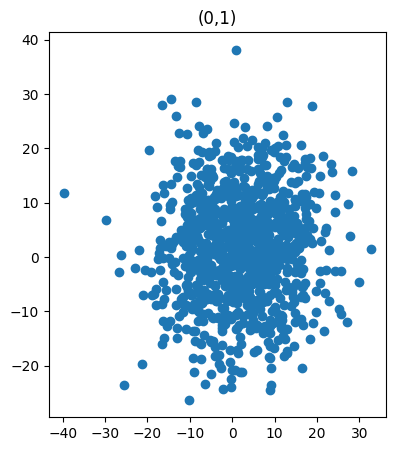

In [122]:
def show_points(X):
    print(X.shape)
    nb_points,dim = X.shape
    plt.figure(figsize=(dim*(dim-1) * 10,5))
    nb_plot=0
    for d1 in range(dim):
        for d2 in range(d1+1,dim):
            xs,ys = [],[]
            nb_plot+=1
            for i in range(nb_points):
                xs.append(X[i][d1])
                ys.append(X[i][d2])
            plt.subplot(1,dim**2,nb_plot)
            plt.title(f"({d1},{d2})")
            plt.scatter(xs,ys)
    plt.show()
    return
n_steps = 1000
dim = 2
points = np.array([torch.normal(mean=2*torch.ones((dim,)), std=10*torch.ones((dim,))) for _ in range(1000)])
show_points(points)

In [123]:
class Net(nn.Module):
    def __init__(self,inpSize,outpSize):
        """
        Ce network sert à sampler epsilon_theta (x_t,t)
        """
        super(Net,self).__init__()
        self.inpsize = inpSize
        self.linear1 = torch.nn.Linear(inpSize,256).to(device)
        self.act = torch.nn.SiLU().to(device)
        self.linear2 = torch.nn.Linear(256,outpSize).to(device)

    def forward(self,x,t):
        x = x.to(device)
        y = torch.zeros((self.inpsize,)).to(device)
        y[:dim] = x
        y[dim] = t
        out = self.linear2(self.act(self.linear1(y))).to(device)
        return out

linearNet = Net(dim+1,dim)

In [124]:
class Diff(nn.Module):
    def __init__(self,network, num_timesteps,beta_start = 0.0001, beta_end = 0.02, device = "cpu"):
        super(Diff,self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start,beta_end,num_timesteps,dtype=torch.float32)
        self.betas = self.betas.to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas,axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5
        self.betas = torch.linspace(beta_start,beta_end,num_timesteps,dtype=torch.float32).to(device)
    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps] # bs

        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps] # bs
        s1 = s1.reshape(-1) # (bs, 1, 1, 1) for broadcasting
        s2 = s2.reshape(-1) # (bs, 1, 1, 1)
        return s1 * x_start + s2 * x_noise
    def reverse(self,x,t):
        return self.network(x,t)
    def step(self, model_output, timestep, sample):
        t = timestep
        coef_epsilon = (1-self.alphas)/self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1)
        coef_first = 1/self.alphas ** 0.5
        coef_first_t = coef_first[t].reshape(-1)
        #coef_first_t = (1/((self.alphas[t])**0.5)).reshape(-1,1)
        pred_prev_sample = coef_first_t*(sample-coef_eps_t*model_output)
        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise)

        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample

In [125]:
def training_loop(model,dataloader,optim,num_ep,num_timesteps,device=device):
    global_step = 0
    losses = []
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            noise = torch.randn(batch.shape).to(device)
            timesteps = torch.randint(0, num_timesteps, (1,)).long().to(device)
            noisy = model.add_noise(batch, noise, timesteps[0])
            noise_pred = model.reverse(noisy, timesteps)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        progress_bar.close()

In [126]:
from torch.utils.data import Dataset, DataLoader

In [127]:
class MultivariateNormalDataset(Dataset):
    def __init__(self, mean,std, num_samples):
        self.data = np.array([torch.normal(mean=mean, std=std) for _ in range(num_samples)])
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

In [128]:
num_samples = 10000  # Number of samples
batch_size = 32     # Batch size
mean = 2*torch.ones((dim,))
std = 10*torch.ones((dim,))
dataset = MultivariateNormalDataset(mean,std, num_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [129]:

lr = 1e-4
num_epochs = 100
num_timesteps = 200
network = Net(dim+1,dim)
network = network.to(device)
model = Diff(network,num_timesteps,device = device)

optimizer = torch.optim.Adam(network.parameters(), lr=lr)
training_loop(model,dataloader,optimizer,num_epochs,num_timesteps)

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [132]:
def genere_un_point():
    sample = torch.randn(dim).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        timesteps = list(range(model.num_timesteps))[::-1]
        for i,t in enumerate(timesteps):
            time_tensor = (torch.ones(dim,1) * t).long().to(device)
            residual = model.reverse(sample,t)
            sample = model.step(residual,t,sample)
    return sample

(20, 2)


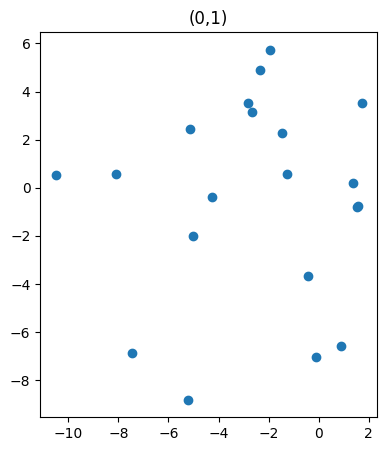

(40, 2)


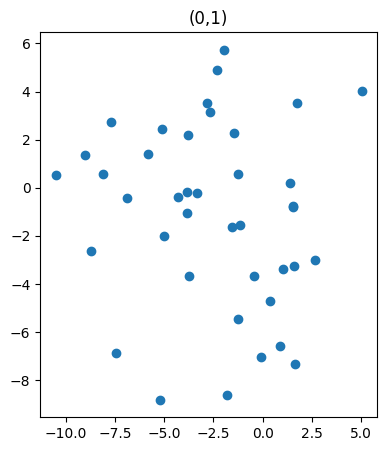

(60, 2)


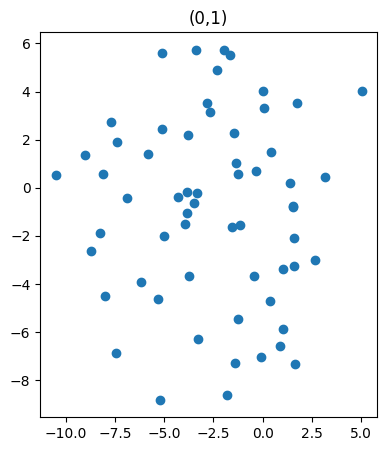

(80, 2)


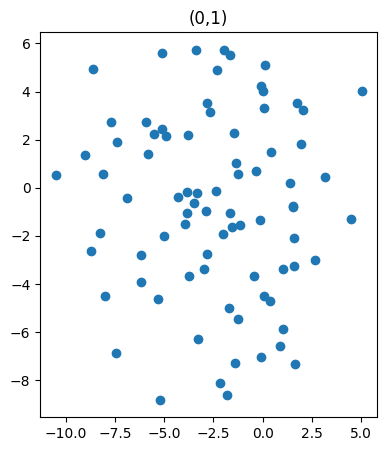

(100, 2)


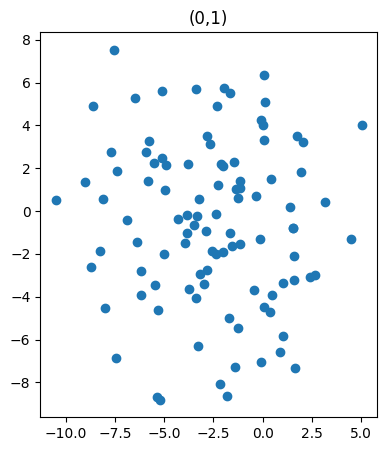

(120, 2)


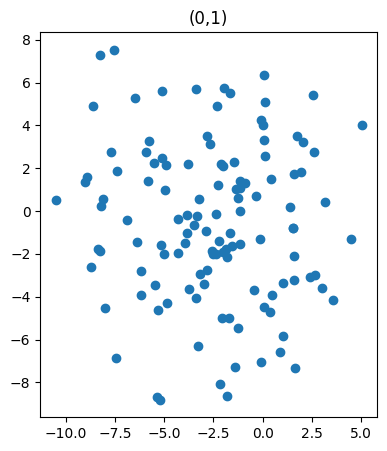

(140, 2)


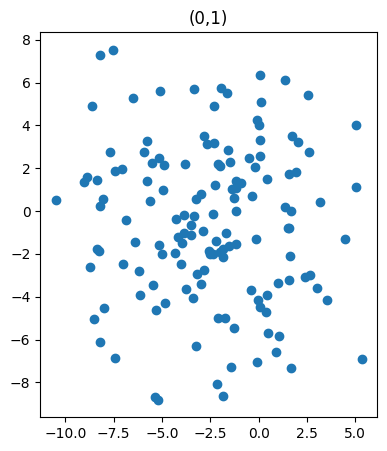

(160, 2)


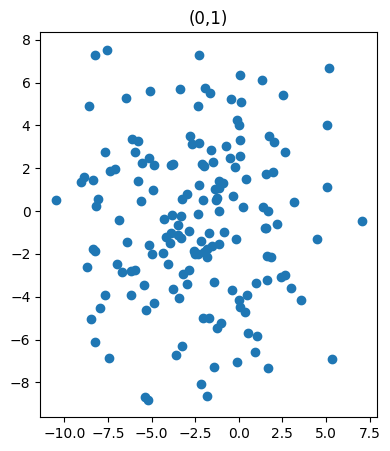

(180, 2)


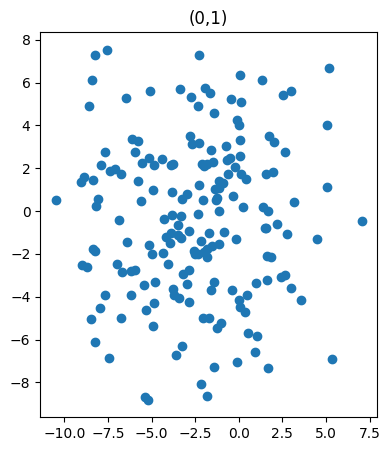

(200, 2)


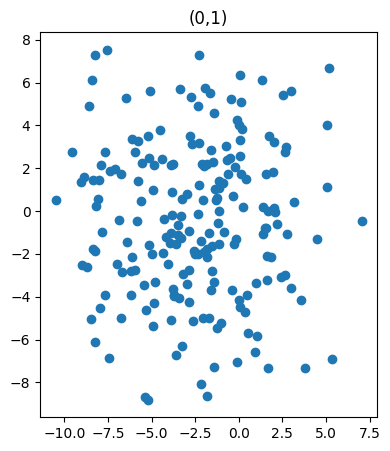

(220, 2)


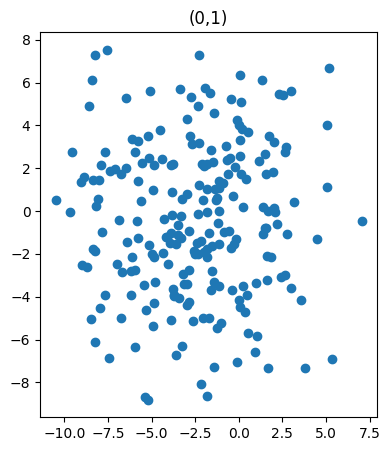

(240, 2)


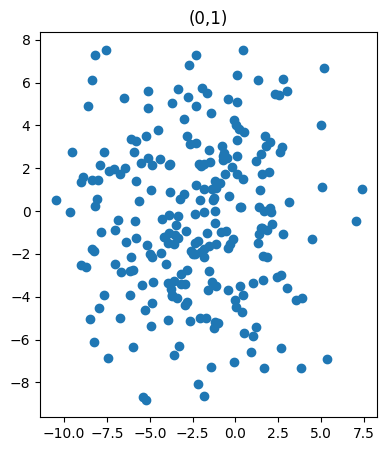

(260, 2)


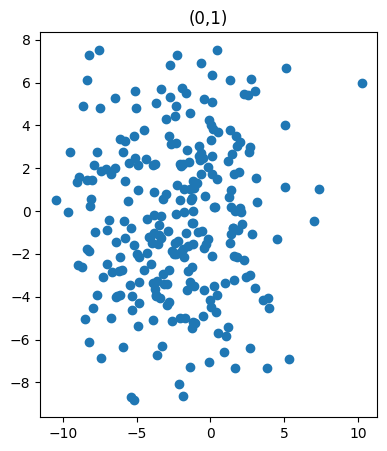

(280, 2)


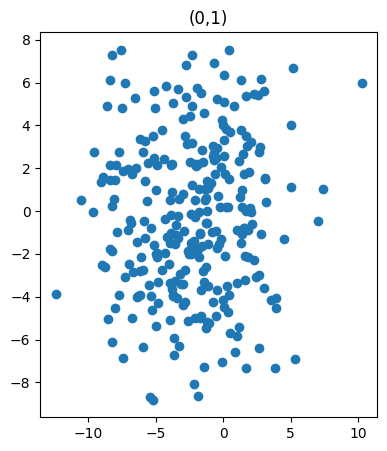

(300, 2)


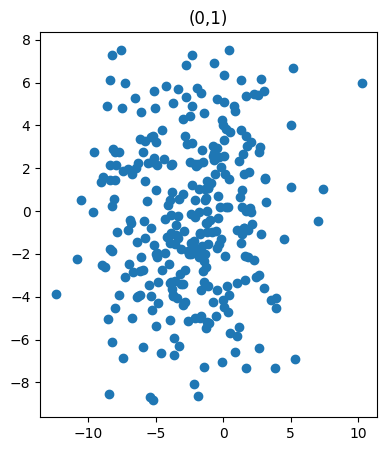

(320, 2)


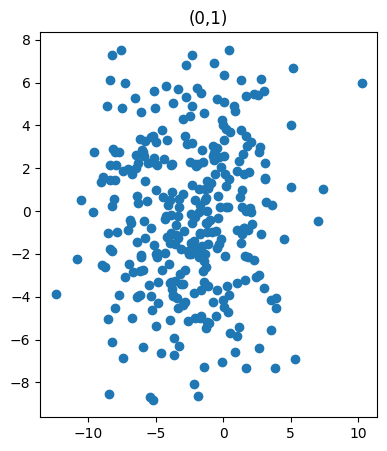

(340, 2)


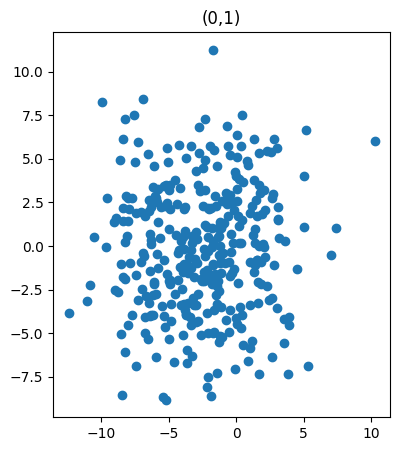

(360, 2)


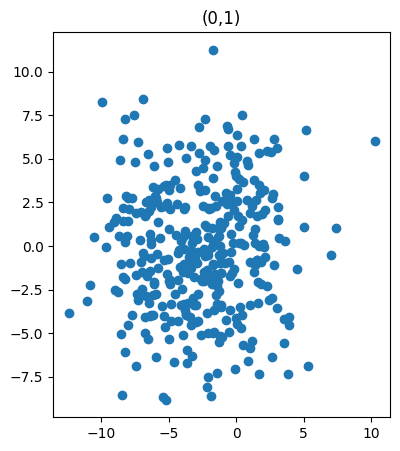

(380, 2)


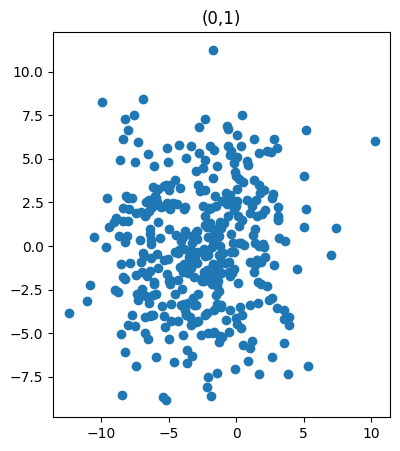

(400, 2)


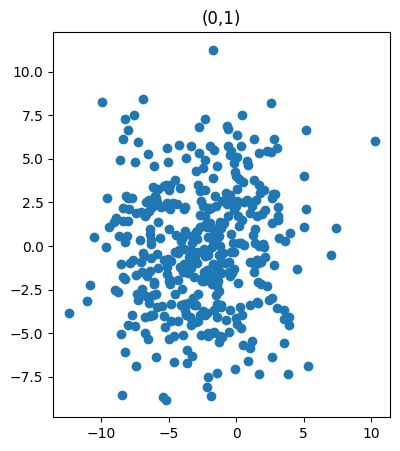

(420, 2)


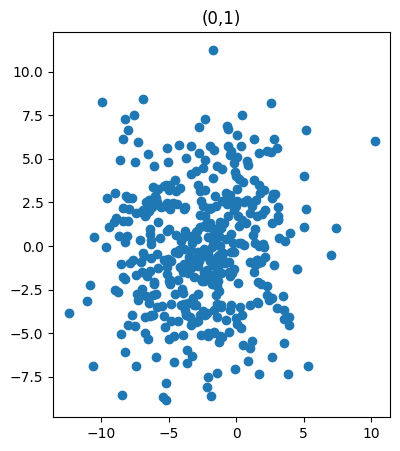

(440, 2)


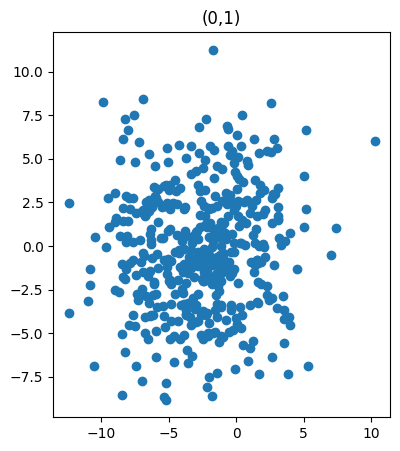

(460, 2)


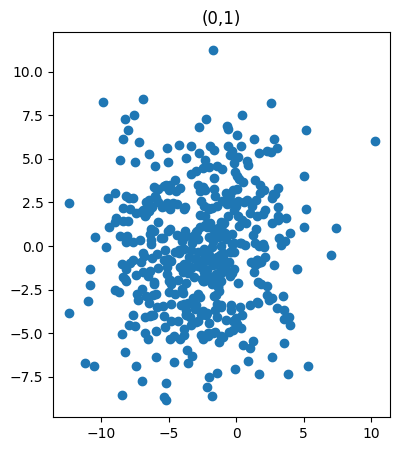

(480, 2)


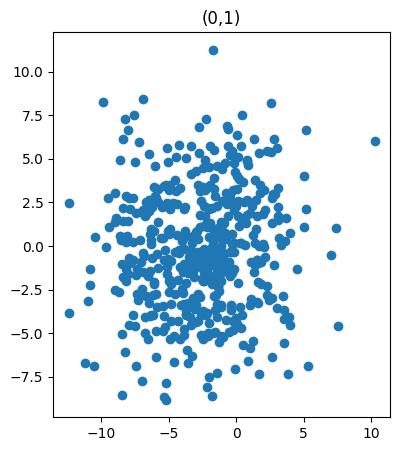

(500, 2)


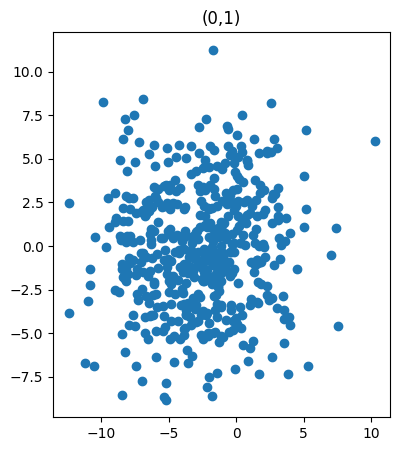

(520, 2)


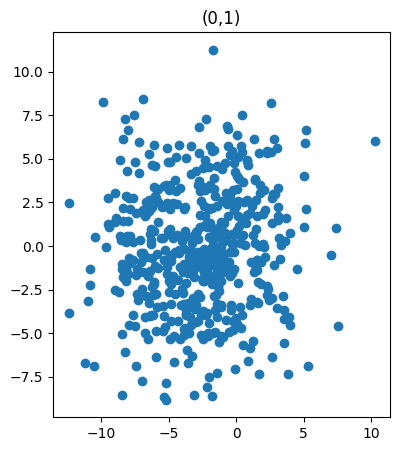

KeyboardInterrupt: 

In [134]:
X = []
while True:
    X.append(genere_un_point()[0])
    if len(X) % 20 == 0 and len(X)>0:
        Y = [x.cpu() for x in X]
        show_points(np.array(Y))